In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

# Question #5 (a)

In [2]:
raw_data = pd.read_csv('Koop-Tobias.csv')
raw_data.head()

,PERSONID,EDUC,LOGWAGE,POTEXPER,TIMETRND,ABILITY,MOTHERED,FATHERED,BRKNHOME,SIBLINGS
0,1,13,1.82,1,0,1.0,12,12,0,1
1,1,18,3.29,3,7,1.0,12,12,0,1
2,1,18,3.21,5,9,1.0,12,12,0,1
3,1,18,3.06,6,10,1.0,12,12,0,1
4,2,15,2.14,4,6,1.5,12,12,0,1


In [3]:
X = raw_data.drop(columns=['PERSONID', 'LOGWAGE', 'TIMETRND'])
X = sm.add_constant(X)
y = raw_data['LOGWAGE']

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                LOGWAGE   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     546.6
Date:                Tue, 12 Mar 2019   Prob (F-statistic):               0.00
Time:                        01:32:07   Log-Likelihood:                -12255.
No. Observations:               17919   AIC:                         2.453e+04
Df Residuals:                   17911   BIC:                         2.459e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9897      0.034     29.198      0.0

#### variable selection

In [4]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
"""Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
"""
lm = LinearRegression()
rfe = RFE(lm, 7) 
rfe = rfe.fit(X, y)
print(rfe.support_) 
print(rfe.ranking_)  

[False  True  True  True  True  True  True  True]
[2 1 1 1 1 1 1 1]


#### linearity

In [5]:
y_fit = results.predict(X)
y_fit_2 = np.power(y_fit, 2)
y_fit_3 = np.power(y_fit, 3)
y_fit_4 = np.power(y_fit, 4)
X_ramsey = X
X_ramsey['y_fit_2'] = np.power(y_fit, 2)
X_ramsey['y_fit_3'] = np.power(y_fit, 3)
X_ramsey['y_fit_4'] = np.power(y_fit, 4)

results_ramsey = sm.OLS(y, X_ramsey).fit()

R = np.array(([0,0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,1]))

print(results_ramsey.f_test(R))

<F test: F=array([[4.81049277]]), p=0.0023789976820426007, df_denom=17908, df_num=3>


#### heteroskedasticity

In [6]:
u_fit = y - y_fit
u_fit_2 = np.power(u_fit, 2)
x_bp = sm.add_constant(y_fit)
x_white = pd.DataFrame()
x_white['y_fit'] = y_fit
x_white['y_fit_2'] = y_fit_2
x_white = sm.add_constant(x_white)

results_bp = sm.OLS(u_fit_2, x_bp).fit()
results_white = sm.OLS(u_fit_2, x_white).fit()

R = np.array(([0,1,0], [0,0,1]))

In [7]:
print(results_bp.summary())
print(results_white.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     82.33
Date:                Tue, 12 Mar 2019   Prob (F-statistic):           1.27e-19
Time:                        01:32:07   Log-Likelihood:                -9988.0
No. Observations:               17919   AIC:                         1.998e+04
Df Residuals:                   17917   BIC:                         2.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0669      0.033     -2.037      0.0

In [8]:
print(results_white.f_test(R))

<F test: F=array([[41.24043977]]), p=1.3508472578390087e-18, df_denom=17916, df_num=2>


#### multicollinearity

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X = raw_data.drop(columns=['PERSONID', 'LOGWAGE', 'TIMETRND'])
X = sm.add_constant(X)
x_matrix = X.values
for i in range(1, X.shape[1]):
    print(vif(x_matrix,i))

1.4668680874104125
1.071586657183698
1.6263334856728235
2.0003700037781957
1.9787587704634118
1.0122740048939267
1.1243151384654102


In [10]:
X.corr()

,const,EDUC,POTEXPER,ABILITY,MOTHERED,FATHERED,BRKNHOME,SIBLINGS
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDUC,NaN,1.000000,-0.218704,0.527899,0.347798,0.373626,-0.107157,-0.187302
POTEXPER,NaN,-0.218704,1.000000,-0.222156,-0.140324,-0.147247,0.024923,0.111327
ABILITY,NaN,0.527899,-0.222156,1.000000,0.450126,0.449160,-0.060873,-0.242717
MOTHERED,NaN,0.347798,-0.140324,0.450126,1.000000,0.678523,-0.030638,-0.301923
FATHERED,NaN,0.373626,-0.147247,0.449160,0.678523,1.000000,-0.051096,-0.255517
BRKNHOME,NaN,-0.107157,0.024923,-0.060873,-0.030638,-0.051096,1.000000,0.030289
SIBLINGS,NaN,-0.187302,0.111327,-0.242717,-0.301923,-0.255517,0.030289,1.000000


#### outlier

In [11]:
import matplotlib.pyplot as plt
results = sm.OLS(y, X).fit()
influence = results.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance

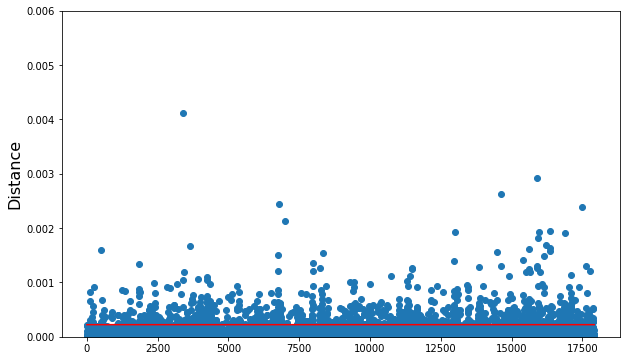

In [12]:
plt.figure(figsize=(10,6))
plt.ylim([0,0.006])
plt.ylabel('Distance', fontsize=16)
plt.scatter(np.arange(len(c)),c)
plt.plot(np.arange(len(c)),np.full(c.shape,4/len(c),dtype=float),'r')

In [13]:
outlier = c>4/len(c)
outlier.sum()

1064

In [14]:
from statsmodels.regression.linear_model import OLSResults
outlier = results.outlier_test()

In [15]:
outlier[outlier['student_resid'].abs()>2].count()

student_resid    886
unadj_p          886
bonf(p)          886
dtype: int64

#### endogeneity

In [16]:
from statsmodels.sandbox.regression.gmm import IV2SLS
y = raw_data['LOGWAGE']
X = raw_data.drop(columns=['PERSONID', 'LOGWAGE', 'TIMETRND','MOTHERED', 'FATHERED'])
X = sm.add_constant(X)
X_iv = raw_data.drop(columns=['PERSONID', 'LOGWAGE', 'TIMETRND','EDUC'])
resultIV = IV2SLS(y, X, X_iv).fit()

In [17]:
resultIV.spec_hausman()

(23.773561500875772, 6.880764792902928e-06, 2)

In [18]:
Z = raw_data.drop(columns=['PERSONID', 'LOGWAGE', 'TIMETRND','EDUC'])
Z = sm.add_constant(Z)
X_i = raw_data['EDUC']
results_onestep = sm.OLS(X_i, Z).fit()
X_i_fit = results_onestep.predict(Z)
X['X_i_fit'] = X_i_fit
results_twostep = sm.OLS(y, X).fit()
results_twostep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LOGWAGE   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     637.4
Date:                Tue, 12 Mar 2019   Prob (F-statistic):               0.00
Time:                        01:33:39   Log-Likelihood:                -12256.
No. Observations:               17919   AIC:                         2.453e+04
Df Residuals:                   17912   BIC:                         2.458e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2295      0.173      1.327      0.184      -0.109       0.568
EDUC           0.0712      0.002     31.538      0.000       0.067       0.076
POTEXPER       0.0423      0.001     38.893      0.000       0.040       0.044
ABILITY        0.0228      0.014      1.653      0.098      -0.004       0.050
BRKNHOME      -0.0296      0.011     -2.648      0.008      -0.051      -0.008
SIBLINGS       0.0066      0.002      3.516      0.000       0.003       0.010
X_i_fit        0.0626      0.013      4.732      0.000       0.037       0.089
==============================================================================
Omnibus:                     1111.748   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.662
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                       4.393   Cond. No.                         979.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Question #5 (b)

In [19]:
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

In [20]:
mod = smf.quantreg('LOGWAGE ~ EDUC + POTEXPER', raw_data)
res = mod.fit(q=.3)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                LOGWAGE   Pseudo R-squared:              0.08548
Model:                       QuantReg   Bandwidth:                     0.07576
Method:                 Least Squares   Sparsity:                        1.282
Date:                Tue, 12 Mar 2019   No. Observations:                17919
Time:                        01:33:39   Df Residuals:                    17916
                                        Df Model:                            2
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7279      0.033     21.836      0.000       0.663       0.793
EDUC           0.0830      0.002     34.891      0.000       0.078       0.088
POTEXPER       0.0364      0.001     32.200      0.000       0.034       0.039
==============================================================================
"""

In [21]:
res = mod.fit(q=.5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                LOGWAGE   Pseudo R-squared:               0.1063
Model:                       QuantReg   Bandwidth:                     0.08266
Method:                 Least Squares   Sparsity:                        1.109
Date:                Tue, 12 Mar 2019   No. Observations:                17919
Time:                        01:33:39   Df Residuals:                    17916
                                        Df Model:                            2
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6945      0.031     22.190      0.000       0.633       0.756
EDUC           0.1012      0.002     45.843      0.000       0.097       0.106
POTEXPER       0.0410      0.001     39.906      0.000       0.039       0.043
==============================================================================
"""

In [22]:
res = mod.fit(q=.9)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                LOGWAGE   Pseudo R-squared:               0.1102
Model:                       QuantReg   Bandwidth:                     0.06699
Method:                 Least Squares   Sparsity:                        2.498
Date:                Tue, 12 Mar 2019   No. Observations:                17919
Time:                        01:33:39   Df Residuals:                    17916
                                        Df Model:                            2
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2689      0.042     30.052      0.000       1.186       1.352
EDUC           0.0989      0.003     33.584      0.000       0.093       0.105
POTEXPER       0.0411      0.001     31.829      0.000       0.039       0.044
==============================================================================
"""

In [23]:
LS = smf.ols('LOGWAGE ~ EDUC + POTEXPER', raw_data).fit()
LS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LOGWAGE   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1687.
Date:                Tue, 12 Mar 2019   Prob (F-statistic):               0.00
Time:                        01:33:39   Log-Likelihood:                -12444.
No. Observations:               17919   AIC:                         2.489e+04
Df Residuals:                   17916   BIC:                         2.492e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7942      0.027     29.028      0.000       0.741       0.848
EDUC           0.0939      0.002     48.636      0.000       0.090       0.098
POTEXPER       0.0374      0.001     41.613      0.000       0.036       0.039
==============================================================================
Omnibus:                     1067.458   Durbin-Watson:                   0.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1863.394
Skew:                          -0.464   Prob(JB):                         0.00
Kurtosis:                       4.279   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""